In [1]:
%load_ext autoreload
%autoreload 2

from utils import *
from dataset_prepare import *

import pickle

from matplotlib import pyplot as plt

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets.standard_dataset import StandardDataset
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.metrics import ClassificationMetric
from sklearn.metrics import classification_report
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

from IPython.display import Markdown, display

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from tqdm import tqdm
import imblearn

pip install 'aif360[inFairness]'


In [2]:
df = load_dataset()
df

,Num_Acc,trajet,catr,circ,nbv,prof,plan,surf,infra,situ,...,atm,col,catv,obs,obsm,choc,mortal,pieton,sexe_conducteur,age
0,202200000001,5,4,2,2,1,1,1,0,1,...,1,3,2,0,2,1,0,0,1,14
1,202200000001,5,4,2,2,1,1,1,0,1,...,1,3,2,0,2,1,0,0,1,74
2,202200000002,0,4,2,2,1,1,1,0,1,...,1,3,3,0,2,8,0,0,1,34
3,202200000002,4,4,2,2,1,1,1,0,1,...,1,3,3,0,2,8,0,0,1,52
4,202200000003,0,3,-1,2,1,1,1,5,1,...,1,2,3,0,2,1,0,0,1,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126656,202200055300,5,3,2,2,1,2,7,0,3,...,9,6,3,1,0,1,1,0,1,27
126657,202200055301,5,3,2,2,1,1,1,0,1,...,1,3,3,0,0,8,0,0,0,20
126659,202200055301,5,3,2,2,1,1,1,0,1,...,1,3,3,0,0,8,0,0,0,69
126660,202200055302,1,3,3,4,1,1,1,0,1,...,1,2,5,0,2,1,0,0,1,30


In [3]:
label = 'mortal'

# Récupération des ensembles de train/test
X_train, X_test, y_train, y_test = test_train_sets(df)
df = df.drop(columns='Num_Acc')

In [4]:
dataset_orig_train, dataset_orig_test = prepare_standard_dataset(X_train, y_train, X_test, y_test, label)

In [5]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(117678, 24)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sexe_conducteur']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['trajet', 'catr', 'circ', 'nbv', 'prof', 'plan', 'surf', 'infra', 'situ', 'vma', 'mois', 'lum', 'dep', 'agg', 'int', 'atm', 'col', 'catv', 'obs', 'obsm', 'choc', 'pieton', 'sexe_conducteur', 'age']


In [6]:
privileged_groups=[{'sexe_conducteur': 1}]
unprivileged_groups = [{'sexe_conducteur' : 0}]

## Repondération
Utilisation de l'outil de repondération de `aif360` et affichage du résultat obtenu.

In [7]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.080457


In [8]:
# 0 -> Femme et 1 -> Homme
RW = Reweighing(privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [9]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [10]:
# valeurs catégorielles
categorical_features = ['trajet', 'catr', 'circ', 'nbv', 'prof',
                        'plan', 'surf', 'vma', 'lum', 'agg', 
                        'int', 'atm', 'col', 'catv', 'obs', 'obsm', 'choc', 'pieton',
                        'sexe_conducteur', 'infra', 'situ']
# valeurs numériques
numerical_features = ['dep','age', 'mois']

print("numerical : ", numerical_features)
print("categorical : ", categorical_features)

numerical :  ['dep', 'age', 'mois']
categorical :  ['trajet', 'catr', 'circ', 'nbv', 'prof', 'plan', 'surf', 'vma', 'lum', 'agg', 'int', 'atm', 'col', 'catv', 'obs', 'obsm', 'choc', 'pieton', 'sexe_conducteur', 'infra', 'situ']


In [11]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

In [12]:
X_train = dataset_transf_train.convert_to_dataframe()[0].drop(columns=['mortal'])
y_train = dataset_transf_train.convert_to_dataframe()[0]['mortal']
X_test = dataset_orig_test.convert_to_dataframe()[0].drop(columns=['mortal'])
y_test = dataset_orig_test.convert_to_dataframe()[0]['mortal']

In [13]:
from utils import custom_RFC
import imblearn

dt = custom_RFC(random_state=42)
clf = imblearn.pipeline.Pipeline(
    [
        ('preprocessor', transformations),
        ('classifier', dt)
    ])
clf = clf.fit(X_train, y_train, classifier__sample_weight=dataset_orig_train.instance_weights)

preds = clf.predict(X_test)

clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.9891398562178148, 0.7555738243998684)

In [14]:
pickle.dump(clf, open('models/rfc_reweight_model.sav', 'wb'))

In [15]:
print_conf_matrix(clf, y_test, preds)

TypeError: print_conf_matrix() takes 2 positional arguments but 3 were given

In [16]:
print_metrics(clf, X_test, y_test, df, categorical_features)

sexe_conducteur 0
disparate_impact 0.9492182363968904 0.6355715740529334
P_rule_disparate_impact 0.9492182363968904 0.6355715740529334
demography_parity -0.01313048010351689 -0.022439373005842936
pieton 1
disparate_impact 0.5614449416588075 1.0800450805571133
P_rule_disparate_impact 0.5614449416588075 0.9258872782274753
demography_parity -0.1167927597721034 0.004422364056385214


In [17]:
def sensible_error_rate (X, desired_output, group, target, label):
   cardGlob1 = len(X[(X[label]==1) & (X[target] == group)])
   cardGlob2 = len(X[(X[label]==0) & (X[target] == group)])
   cardGlob3 = len(X[(X[label]==1) & (X[target] == np.absolute(group-1))])
   cardGlob4 = len(X[(X[label]==0) & (X[target] == np.absolute(group-1))])
   cardPred1 = len(X[(X['pred']==desired_output) & (X[label]==1) & (X[target] == group)])
   cardPred2 = len(X[(X['pred']==desired_output) & (X[label]==0) & (X[target] == group)])
   cardPred3 = len(X[(X['pred']==desired_output) & (X[label]==1) & (X[target] == np.absolute(group-1))])
   cardPred4 = len(X[(X['pred']==desired_output) & (X[label]==0) & (X[target] == np.absolute(group-1))])

   return cardPred1/cardGlob1, cardPred2/cardGlob2, cardPred3/cardGlob3, cardPred4/cardGlob4

In [18]:
target = 'sexe_conducteur'
X_error_rate_1 = pd.DataFrame()
X_error_rate_1[target] = X_test[target]
X_error_rate_1[label] = y_test
X_error_rate_1['pred'] = preds
result = sensible_error_rate (X_error_rate_1, 1, 0, target, label)
print("Les femmes conductrices impliquées dans un accident mortel : {0} \nLes femmes conductrices impliquées dans un accident non mortel : {1} \nLes hommes conducteurs impliquées dans un accident mortel : {2} \nLes hommes conducteurs impliquées dans un accident non mortel : {3} \n".format(result[0], result[1], result[2], result[3]))

Les femmes conductrices impliquées dans un accident mortel : 0.6038338658146964 
Les femmes conductrices impliquées dans un accident non mortel : 0.23083929733246583 
Les hommes conducteurs impliquées dans un accident mortel : 0.5942028985507246 
Les hommes conducteurs impliquées dans un accident non mortel : 0.23654431342715862 



## Disparate impact remover
Utilisation de l'outil de `Disparate impact remover` de `aif360` et affichage du résultat obtenu.

In [19]:
label = 'mortal'

df = load_dataset()
# Récupération des ensembles de train/test
X_train, X_test, y_train, y_test = test_train_sets(df)

In [20]:
dataset_orig_train, dataset_orig_test = prepare_standard_dataset(X_train, y_train, X_test, y_test, label, transform=True)

In [21]:
protected = 'sexe_conducteur'

index = dataset_orig_train.feature_names.index(protected)

DIs = []
for level in tqdm(np.linspace(0., 1., 11)):
    di = DisparateImpactRemover(repair_level=level)
    train_repd = di.fit_transform(dataset_orig_train)
    test_repd = di.fit_transform(dataset_orig_test)

    X_tr = np.delete(train_repd.features, index, axis=1)
    X_te = np.delete(test_repd.features, index, axis=1)
    
    y_tr = train_repd.labels.ravel()
    
    dt = custom_RFC(random_state=42)
    dt.fit(X_tr, y_tr)
    
    test_repd_pred = test_repd.copy()
    test_repd_pred.labels = dt.predict(X_te)

    p = [{protected: 1}]
    u = [{protected: 0}]
    cm = BinaryLabelDatasetMetric(test_repd_pred, privileged_groups=p, unprivileged_groups=u)
    DIs.append(cm.disparate_impact())

100%|██████████| 11/11 [05:21<00:00, 29.19s/it]


In [22]:
%matplotlib notebook

plt.plot(np.linspace(0, 1, 11), DIs, marker='o')
plt.plot([0, 1], [1, 1], 'g')
plt.plot([0, 1], [0.8, 0.8], 'r')
plt.ylim([0.4, 1.2])
plt.ylabel('Disparate Impact (DI)')
plt.xlabel('repair level')
plt.show()
plt.savefig("disparate_impact_remover.svg")

<IPython.core.display.Javascript object>

In [23]:
protected = 'sexe_conducteur'

index = dataset_orig_train.feature_names.index(protected)

di = DisparateImpactRemover(repair_level=0.9)
train_repd = di.fit_transform(dataset_orig_train)
test_repd = di.fit_transform(dataset_orig_test)

X_tr = np.delete(train_repd.features, index, axis=1)
X_te = np.delete(test_repd.features, index, axis=1)

y_tr = train_repd.labels.ravel()
y_te = test_repd.labels.ravel()

dt = custom_RFC(random_state=42)
dt.fit(X_tr, y_tr)

test_repd_pred = test_repd.copy()
preds = dt.predict(X_te)


In [24]:
dt.score(X_tr, y_tr), dt.score(X_te, y_te)

(0.9887149679634256, 0.7598816178888523)

In [25]:
X_train = train_repd.convert_to_dataframe()[0]
X_test = test_repd.convert_to_dataframe()[0]
y_train = train_repd.convert_to_dataframe()[0]['mortal']
y_test = test_repd.convert_to_dataframe()[0]['mortal']

In [26]:
print_conf_matrix(dt, y_test, preds)

TypeError: print_conf_matrix() takes 2 positional arguments but 3 were given

In [27]:
print_metrics(clf, X_test, y_test, df, categorical_features)

sexe_conducteur 0
disparate_impact 1.0028235328213417 0.6355715740529334
P_rule_disparate_impact 0.9971844170694738 0.6355715740529334
demography_parity 0.0008044019750252929 -0.022439373005842936
pieton 1
disparate_impact 0.5234323412501591 1.0800450805571133
P_rule_disparate_impact 0.5234323412501591 0.9258872782274753
demography_parity -0.14237749141526124 0.004422364056385214


In [28]:
def sensible_error_rate (X, desired_output, group, target, label):
   cardGlob1 = len(X[(X[label]==1) & (X[target] == group)])
   cardGlob2 = len(X[(X[label]==0) & (X[target] == group)])
   cardGlob3 = len(X[(X[label]==1) & (X[target] == np.absolute(group-1))])
   cardGlob4 = len(X[(X[label]==0) & (X[target] == np.absolute(group-1))])
   cardPred1 = len(X[(X['pred']==desired_output) & (X[label]==1) & (X[target] == group)])
   cardPred2 = len(X[(X['pred']==desired_output) & (X[label]==0) & (X[target] == group)])
   cardPred3 = len(X[(X['pred']==desired_output) & (X[label]==1) & (X[target] == np.absolute(group-1))])
   cardPred4 = len(X[(X['pred']==desired_output) & (X[label]==0) & (X[target] == np.absolute(group-1))])

   return cardPred1/cardGlob1, cardPred2/cardGlob2, cardPred3/cardGlob3, cardPred4/cardGlob4

In [29]:
target = 'sexe_conducteur'
X_error_rate_1 = pd.DataFrame()
X_error_rate_1[target] = X_test[target]
X_error_rate_1[label] = y_test
X_error_rate_1['pred'] = preds
result = sensible_error_rate (X_error_rate_1, 1, 0, target, label)
print("Les femmes conductrices impliquées dans un accident mortel : {0} \nLes femmes conductrices impliquées dans un accident non mortel : {1} \nLes hommes conducteurs impliquées dans un accident mortel : {2} \nLes hommes conducteurs impliquées dans un accident non mortel : {3} \n".format(result[0], result[1], result[2], result[3]))

Les femmes conductrices impliquées dans un accident mortel : 0.6325878594249201 
Les femmes conductrices impliquées dans un accident non mortel : 0.21574495770982433 
Les hommes conducteurs impliquées dans un accident mortel : 0.6043478260869565 
Les hommes conducteurs impliquées dans un accident non mortel : 0.23692468619246862 



### Apprentissage de `représentation latente fair`

In [10]:
label = 'mortal'
df = load_dataset()

# Récupération des ensembles de train/test
X_train, X_test, y_train, y_test = test_train_sets(df)
df = df.drop(columns='Num_Acc')

In [11]:
dataset_orig_train, dataset_orig_test = prepare_standard_dataset(X_train, y_train, X_test, y_test, label, transform=True)

In [12]:
TR = LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
         k=10, Ax=0.1, Ay=1.0, Az=2.0,
         verbose=1
        )
TR = TR.fit(dataset_orig_train, maxiter=1000, maxfun=1000)

step: 0, loss: 543.1231041482407, L_x: 5424.296026739358,  L_y: 0.6926443608690013,  L_z: 0.0004285567179108593
step: 250, loss: 543.1231036630564, L_x: 5424.296021732701,  L_y: 0.6926443770415249,  L_z: 0.0004285563723728222
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          250     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.43123D+02    |proj g|=  2.76822D-01
step: 500, loss: 542.663186665013, L_x: 5419.700028837804,  L_y: 0.692321938070427,  L_z: 0.00043092158102503995

At iterate    1    f=  5.42663D+02    |proj g|=  3.10142D-01
  ys=-1.564E-02  -gs= 4.520E-01 BFGS update SKIPPED
step: 750, loss: 542.1621324036682, L_x: 5414.694402260015,  L_y: 0.6918289558225618,  L_z: 0.0004316109221271451
step: 1000, loss: 539.9548873608048, L_x: 5392.648174188612,  L_y: 0.6892271563388668,  L_z: 0.0004213928023839238
step: 1250, loss: 530.1943948348494, L_x: 5295.047904483324,  L_y: 0.6882793675375602,  L

In [13]:
# Transform training data and align features
dataset_transf_train = TR.transform(dataset_orig_train)
dataset_transf_test = TR.transform(dataset_orig_test)

In [14]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())
metric_transf_test = BinaryLabelDatasetMetric(dataset_transf_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Transformed test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_test.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.023930


#### Transformed test dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.009061


In [15]:
from collections import OrderedDict
from aif360.metrics import ClassificationMetric

def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

In [16]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []

class_thresh_arr = np.linspace(0.01, 0.99, 100)

dataset_transf_test_new = dataset_orig_test.copy(deepcopy=True)
dataset_transf_test_new.scores = dataset_transf_test.scores


for thresh in class_thresh_arr:
    
    fav_inds = dataset_transf_test_new.scores > thresh
    dataset_transf_test_new.labels[fav_inds] = 1.0
    dataset_transf_test_new.labels[~fav_inds] = 0.0
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_new, 
                                      unprivileged_groups, privileged_groups,
                                      disp = False)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

/home/erwan/.local/lib/python3.10/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


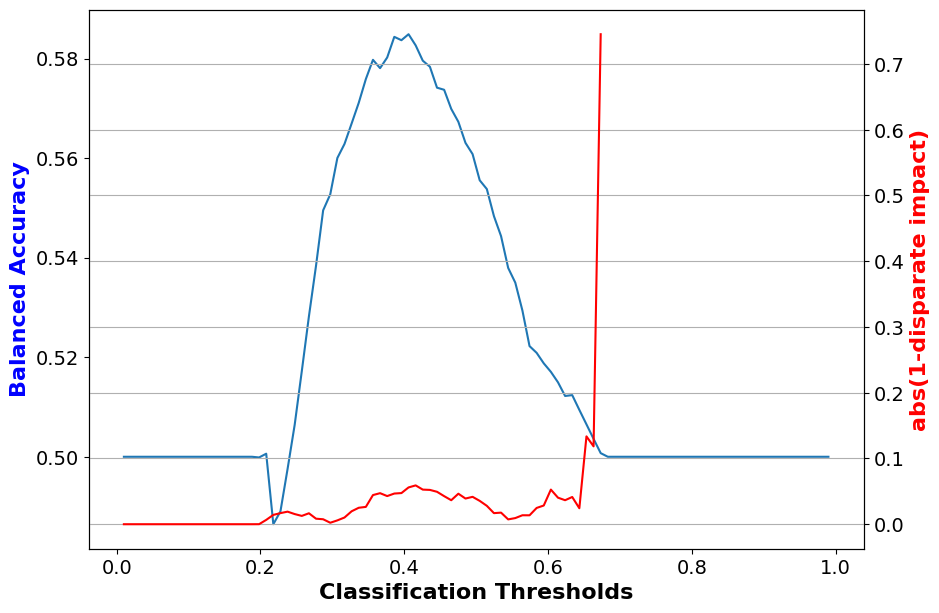

In [17]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [172]:
X_train = dataset_transf_train.convert_to_dataframe()[0].drop(columns=['mortal'])
y_train = dataset_transf_train.convert_to_dataframe()[0]['mortal']

In [173]:
from utils import custom_RFC
import imblearn

clf = custom_RFC(random_state=42)
clf = clf.fit(X_train, y_train)

preds = clf.predict(X_test)

clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.9999915022349122, 0.05567247615915817)

In [174]:
print_conf_matrix(y_test, preds)

In [141]:
print_metrics(clf, X_test, y_test, df, categorical_features)

sexe_conducteur 0
disparate_impact 1.8580323785803239 1.3935242839352429
P_rule_disparate_impact 0.5382037533512064 0.7176050044682752
demography_parity 0.00046007098047202337 0.00021100497798136341


ZeroDivisionError: division by zero